# Chapter 1

## 1.2 Location and Variability Estimators

### Context and Motivation

Understanding how system metrics vary over time is critical for ensuring reliability and performance in production environments. 
This notebook focuses on statistical estimators of central tendency (mean, median) and dispersion (standard deviation, IQR, percentiles).

We apply these estimators to real-world logs from the [Apache LogHub dataset](https://github.com/logpai/loghub), 
analyzing hourly log volumes as a proxy for workload intensity and system activity.


### 1.2.1 Dataset Overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean

sns.set(style='whitegrid')

url = "https://raw.githubusercontent.com/logpai/loghub/refs/heads/master/Apache/Apache_2k.log_structured.csv"
df = pd.read_csv(url)
df.head()

,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...,E2,workerEnv.init() ok <*>
1,2,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6,E3,mod_jk child workerEnv in error state <*>
2,3,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10,E1,jk2_init() Found child <*> in scoreboard slot <*>
3,4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8,E1,jk2_init() Found child <*> in scoreboard slot <*>
4,5,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6,E1,jk2_init() Found child <*> in scoreboard slot <*>


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LineId         2000 non-null   int64 
 1   Time           2000 non-null   object
 2   Level          2000 non-null   object
 3   Content        2000 non-null   object
 4   EventId        2000 non-null   object
 5   EventTemplate  2000 non-null   object
dtypes: int64(1), object(5)
memory usage: 93.9+ KB


### 1.2.2 Initial Data Inspection

In [3]:
df['Time_parsed'] = pd.to_datetime(df['Time'], errors='coerce')
df['Hour'] = df['Time_parsed'].dt.hour
df['DayOfWeek'] = df['Time_parsed'].dt.day_name()
df[['Time', 'Time_parsed', 'Hour', 'DayOfWeek']].head()

,Time,Time_parsed,Hour,DayOfWeek
0,Sun Dec 04 04:47:44 2005,2005-12-04 04:47:44,4,Sunday
1,Sun Dec 04 04:47:44 2005,2005-12-04 04:47:44,4,Sunday
2,Sun Dec 04 04:51:08 2005,2005-12-04 04:51:08,4,Sunday
3,Sun Dec 04 04:51:09 2005,2005-12-04 04:51:09,4,Sunday
4,Sun Dec 04 04:51:09 2005,2005-12-04 04:51:09,4,Sunday


### 1.2.3 Exploratory Analysis

#### 1.2.3.1 Log Volume per Hour

In [4]:
hourly_counts = df['Hour'].value_counts().sort_index()
hourly_counts

Hour
1       2
3      73
4     139
5      80
6     347
7     253
8       1
9      11
10    154
11     27
12     30
13    181
14     14
15     39
16    168
17    159
18     56
19    107
20    159
Name: count, dtype: int64

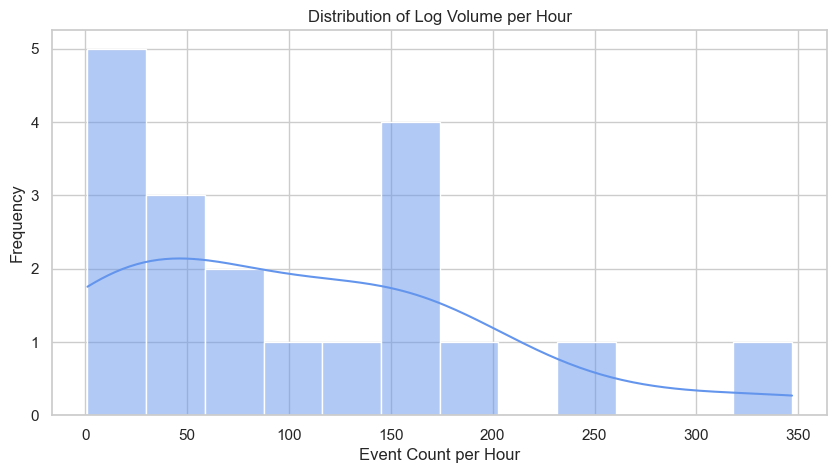

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(hourly_counts, bins=12, kde=True, color='cornflowerblue')
plt.title("Distribution of Log Volume per Hour")
plt.xlabel("Event Count per Hour")
plt.ylabel("Frequency")
plt.show()

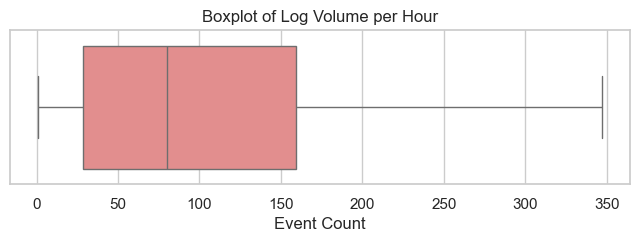

In [6]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=hourly_counts, color='lightcoral')
plt.title("Boxplot of Log Volume per Hour")
plt.xlabel("Event Count")
plt.show()

### 1.2.4 Statistical Summary

In [7]:
mean_ = hourly_counts.mean()
median_ = hourly_counts.median()
std_ = hourly_counts.std()
iqr = hourly_counts.quantile(0.75) - hourly_counts.quantile(0.25)
trimmed = trim_mean(hourly_counts, 0.1)
p95 = hourly_counts.quantile(0.95)

print(f"Mean: {mean_:.2f}")
print(f"Median: {median_:.2f}")
print(f"Standard Deviation: {std_:.2f}")
print(f"IQR: {iqr}")
print(f"Trimmed Mean (10%): {trimmed:.2f}")
print(f"95th Percentile: {p95}")

Mean: 105.26
Median: 80.00
Standard Deviation: 93.77
IQR: 130.5
Trimmed Mean (10%): 97.18
95th Percentile: 262.3999999999998


#### 1.2.4.1 Interpretation

The statistical summary derived from Apache log volumes per hour reveals operational insights that are essential for platform reliability engineering.

**Skewness and Outliers**

- The mean (105.26) is significantly higher than the median (80), indicating a **right-skewed distribution**.
- This suggests that a **few hours experience very high event counts**, pulling the average up.
- These spikes could correspond to:
  - Scheduled maintenance
  - High usage windows
  - Faults producing excessive log noise

**Variability and Dispersion**

- The **standard deviation (93.77)** and **interquartile range (130.5)** confirm that the data is **not tightly clustered** — log volumes vary heavily across hours.
- Variability is **not confined to extreme cases**; even the core of the distribution (the IQR) is wide.

**Robust Estimators**

- The **trimmed mean (97.18)** provides a stable estimate by removing the top and bottom 10% of values — this helps summarize typical behavior.
- The **95th percentile (262.4)** defines the upper limit for what is considered “normal” in most production scenarios.
  - Any hour exceeding this threshold can be treated as a **candidate for alerting or anomaly review**.

**SRE and Engineering Implications**

| Estimator         | Operational Use Case                                       |
|-------------------|------------------------------------------------------------|
| Median            | SLO definition, central tendency under load                |
| Trimmed Mean      | Management dashboards, avoids reacting to spikes           |
| Std Dev / IQR     | Alert thresholds, release monitoring, capacity planning    |
| 95th Percentile   | High-load scenarios, alert tuning, long-tail behavior      |

**Result**

Understanding system behavior through robust statistical estimators allows for better engineering decisions, more resilient monitoring thresholds, and stronger interpretations of platform load patterns. 
This type of variability analysis is fundamental in designing systems that are observable and reliable at scale.

### 1.2.5 Final Considerations

Using robust statistical estimators such as **median**, **trimmed mean**, **IQR**, and **p95** is fundamental in SRE and platform monitoring.

They allow us to:
- Detect and explain irregular workload behavior
- Set realistic and resilient alert thresholds
- Track operational patterns under noisy or non-normal distributions

This analysis lays the foundation for applying thresholds and variability metrics in real-world observability systems.
